In [1]:
%matplotlib inline

from __future__ import print_function
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import itertools
import warnings
import statsmodels

# https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html

In [2]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



            SUNACTIVITY
1970-12-31        104.5
1971-12-31         66.6
1972-12-31         68.9
1973-12-31         38.0
1974-12-31         34.5


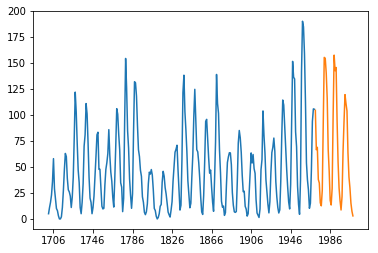

In [34]:
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
#dta.plot(figsize=(12,8));

train_data = dta['1700':'1969']
test_data = dta['1970':'2008']

print(test_data.head())

plt.plot(train_data)
plt.plot(test_data)
plt.show()

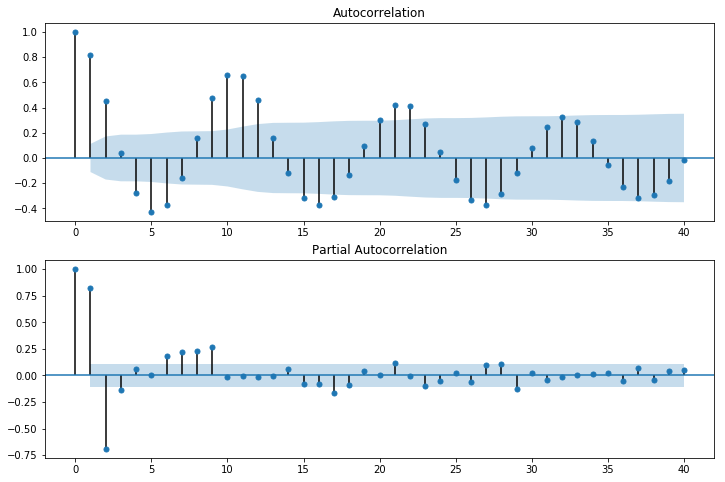

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [36]:
from math import sqrt
import numpy as np


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Fit a model to the data
# Define the d and q parameters to take any value between 0 and 1
q = range(0, 1)
d = range(0, 3)
# Define the p parameters to take any value between 0 and 3
p = range(0, 8)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d,q))


ARMA_model = []
AIC = []
RMS = []

arma_mod = statsmodels.tsa.arima_model.ARIMA(dta,order=(pdq[3]))

actual = np.asarray([test_data["SUNACTIVITY"][i] for i in range(len(test_data))])

for param in pdq:
    try:
        #arma_mod = sm.tsa.ARMA(dta, param).fit(disp=False)
        arma_mod = statsmodels.tsa.arima_model.ARIMA(train_data,order=param).fit()
        aic = arma_mod.aic
        AIC.append(aic)
        ARMA_model.append([param])
        
        # Compute the R2 value
        predictions = arma_mod.predict(start='1970', end='2008')       
        rms = rmse(actual, predictions)
        
        RMS.append(rms)
        
        #print(len(predictions),len(actual))
        print(param,aic,rms)
    
    except:
        continue
        
print('The smallest AIC is {} for model ARMA{}'.format(min(RMS), ARMA_model[RMS.index(min(RMS))][0]))

(0, 0, 0) 2740.16997851 52.5938294679
(0, 1, 0) 2452.33402451 82.7105867865
(0, 2, 0) 2423.54649873 83.0324977996
(1, 0, 0) 2440.1233105605734 51.5219588495
(1, 1, 0) 2363.1258307433736 82.7164495052
(1, 2, 0) 2425.3207337190097 83.0199071707
(2, 0, 0) 2269.911863970714 50.029819271
(2, 1, 0) 2345.9093594872447 82.8934106915
(2, 2, 0) 2426.2590018915666 82.9310196326
(3, 0, 0) 2269.5100489818515 49.1804764908
(3, 1, 0) 2320.4099311530836 83.8061937877
(3, 2, 0) 2412.9713315540257 82.836291397
(4, 0, 0) 2270.965101505826 49.6481971871
(4, 1, 0) 2313.4999319019357 84.5130048456
(4, 2, 0) 2411.0712530810742 82.8313474297
(5, 0, 0) 2272.7689088716447 49.5127155166
(5, 1, 0) 2285.385790593193 86.0378981038
(5, 2, 0) 2400.0260436980698 82.8513431681
(6, 0, 0) 2265.6108851017543 49.0355002414
(6, 1, 0) 2262.8695330389482 86.5227912445
(6, 2, 0) 2383.3234394812807 82.9530466705
(7, 0, 0) 2255.756187035966 46.2834869898
(7, 1, 0) 2243.020222667713 86.3205144127
(7, 2, 0) 2359.3256288703915 83.6

119.563838035
            FORECAST_LOWER  FORECAST_UPPER
DATE                                      
1970-12-31       60.083333      119.563838
1971-12-31       19.626366      116.906428
1972-12-31      -18.492835      101.427711
1973-12-31      -43.151171       83.988270
1974-12-31      -48.593505       79.936815


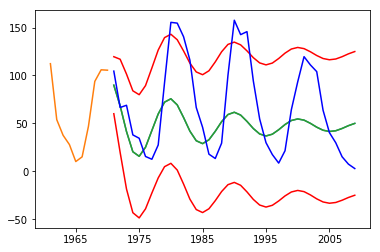

In [86]:
# Now we fit the model
arma_mod = statsmodels.tsa.arima_model.ARIMA(train_data, ARMA_model[RMS.index(min(RMS))][0]).fit(disp=False)


forecast, stderr, conf = arma_mod.forecast(39)

print(conf[0][1])

df = pd.DataFrame(columns=['DATE', 'FORECAST'])
for i in range(len(test_data)):
    df.loc[i] = [test_data.index[i], forecast[i]]
df['DATE']=pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df.set_index(['DATE'], inplace=True)    


df_conf = pd.DataFrame(columns=['DATE', 'FORECAST_LOWER','FORECAST_UPPER'])

for i in range(len(test_data)):
    df_conf.loc[i] = [test_data.index[i], conf[i][0],conf[i][1]]

df_conf['DATE']=pd.to_datetime(df_conf['DATE'], format='%Y-%m-%d')
df_conf.set_index(['DATE'], inplace=True)   

print(df_conf.head())

plt.plot(df)
plt.plot(df_conf[0:],c='r')
#plt.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],alpha=0.2, color='r')
#plt.show()


# Plot the prediction
plt.plot(train_data["1960":"1970"])
plt.plot(arma_mod.predict(start='1970', end='2008'))
plt.plot(test_data, c="b")
plt.show()